In [2]:
from ruamel.yaml import YAML
import h5py
yaml = YAML()
with open('/home/synergyai/jth/rcc-classification-research/experiments/config/session_240621.yaml') as f:
    config = yaml.load(f)

split_dict = {}
with open(config['path_split'],'r') as f_split:
    split = f_split.read().splitlines()
    for i, split_name in enumerate(['train', 'valid', 'test']):
        string = split[i]
        string = string.replace('[','').replace(']','').replace("'", "")
        id_list = string.split(', ')
        split_dict[split_name] = id_list

In [3]:
with h5py.File(config['path_data'], 'r', swmr=True) as f:
    start_indexes = []
    accumulated_count = 0
    list_id = []
    for id in split_dict['train']:
        try: 
            shape_pre = f[id]['image']['precontrast_r']['Axial'].shape
            shape_post = f[id]['image']['post_50sec']['Axial'].shape
            shape_late = f[id]['image']['post_5min_r']['Axial'].shape
            shape_mask = f[id]['segmentation']['post_50sec']['Axial'].shape
        except KeyError:
            #print(f'Error in {id}')
            continue

        assert(shape_pre == shape_post == shape_late == shape_mask)
        start_indexes.append(accumulated_count)
        accumulated_count += shape_pre[0]
        list_id.append(id)

In [4]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
class rcc_3d_dataset(Dataset):
    def __init__(self, list_id, config):
        self.config = config

        with h5py.File(config['path_data'], 'r', swmr=True) as f:
            start_indexes = []
            accumulated_count = 0
            new_list_id = []
            for id in list_id:
                try: 
                    shape_pre = f[id]['image']['precontrast_r']['Axial'].shape
                    shape_post = f[id]['image']['post_50sec']['Axial'].shape
                    shape_late = f[id]['image']['post_5min_r']['Axial'].shape
                    shape_mask = f[id]['segmentation']['post_50sec']['Axial'].shape
                except KeyError:
                    continue

                assert(shape_pre == shape_post == shape_late == shape_mask)
                start_indexes.append(accumulated_count)
                accumulated_count += shape_pre[0]
                new_list_id.append(id)

        self.list_id = new_list_id
        self.start_indexes = start_indexes ##
        self.tot_count = accumulated_count ##
        self.path_data = config['path_data']

    def __len__(self):
        return self.tot_count
    
    def __getitem__(self, idx):
        id_index = np.digitize(idx, self.start_indexes)-1
        slice_index = idx - self.start_indexes[id_index]
        image_x = h5py.File(self.path_data, 'r', swmr=True)[self.list_id[id_index]]['image']['precontrast_r']['Axial'][slice_index]
        image_y = h5py.File(self.path_data, 'r', swmr=True)[self.list_id[id_index]]['image']['post_50sec']['Axial'][slice_index]

        image_x = torch.from_numpy((image_x/2000).astype(np.float32))
        image_y = torch.from_numpy((image_y/2000).astype(np.float32))

        return (image_x, image_y)

In [5]:
yaml = YAML()
with open('/home/synergyai/jth/ct-translation-research/config.yaml') as f:
    config = yaml.load(f)

split_dict = {}
with open(config['path_split'],'r') as f_split:
    split = f_split.read().splitlines()
    for i, split_name in enumerate(['train', 'valid', 'test']):
        string = split[i]
        string = string.replace('[','').replace(']','').replace("'", "")
        id_list = string.split(', ')
        split_dict[split_name] = id_list


ds = rcc_3d_dataset(split_dict['train'], config)

In [6]:
dl = DataLoader(ds, batch_size=2, shuffle=True)

torch.Size([2, 512, 512]) torch.Size([2, 512, 512])


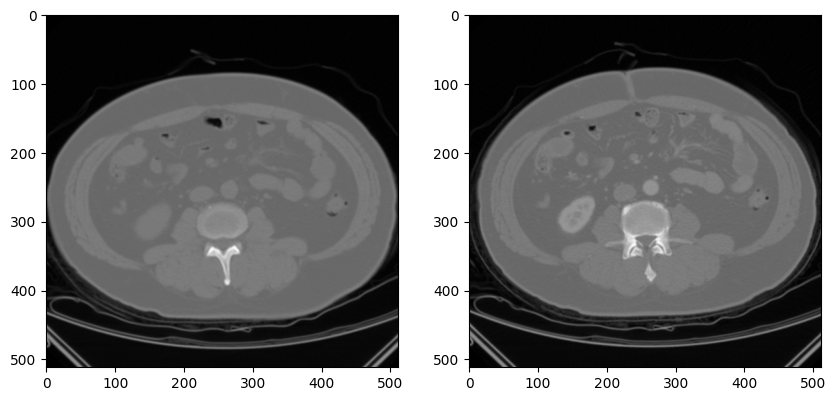

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))

for x, y in dl:
    print(x.shape, y.shape)
    ax[0].imshow(x[0], cmap = 'gray')
    ax[1].imshow(y[0], cmap = 'gray')
    fig.savefig('test.png')
    break

In [8]:
class rcc_dataset(Dataset):
    def __init__(self, image_path, label_path, verbose = True, standardize = True):
        self.label_memmap = np.memmap(label_path, dtype=np.int16, mode='r')
        length = self.label_memmap.shape[0]
        self.image_memmap = np.memmap(image_path, dtype=np.float32, mode='r', shape = (length, 3, 224, 224))
        self.malig_count = np.count_nonzero(self.label_memmap)
        self.benign_count = length - self.malig_count
        if verbose:
            print(f'Malignant slices: {self.malig_count}, Benign slices: {self.benign_count}')

        # self.mean, std carries params for z-standardization. may not be equal to the actual mean, std of the dataset
        self.mean = np.mean(self.image_memmap)
        self.std = np.std(self.image_memmap)
        self.standardize = standardize

        self.target_mean = 0.449
        self.target_std = 0.226

    def __len__(self):
        return len(self.label_memmap)

    def __getitem__(self, idx):
        image = self.image_memmap[idx].copy()
        if self.standardize:
            image = (image - self.mean) / self.std * self.target_std + self.target_mean

        label = self.label_memmap[idx].copy()
        label = np.array([label])
        return torch.from_numpy(image), torch.from_numpy(label)
    
    def get_z_params(self):
        print(f'Actual mean: {np.mean(self.image_memmap)}, Actual std: {np.std(self.image_memmap)}')
        return np.mean(self.image_memmap), np.std(self.image_memmap)

    def set_z_params(self, mean, std):
        print(f'Setting mean {self.mean} to {mean}, std {self.std} to {std} for z-standardization')
        self.standardize = True
        self.mean = mean
        self.std = std

48925

In [ ]:
import numpy as np
np.memmap(config['path_data'], dtype='float32', mode='r', shape=(len(split_dict['train']), 3, 224, 224))

In [ ]:
def CreateDatasetSynthesis(phase, input_path, contrast1 = 'T1', contrast2 = 'T2'):

    target_file = input_path + "/data_{}_{}.mat".format(phase, contrast1)
    data_fs_s1=LoadDataSet(target_file)
    
    target_file = input_path + "/data_{}_{}.mat".format(phase, contrast2)
    data_fs_s2=LoadDataSet(target_file)

    dataset=torch.utils.data.TensorDataset(torch.from_numpy(data_fs_s1),torch.from_numpy(data_fs_s2))  
    return dataset 



#Dataset loading from load_dir and converintg to 256x256 
def LoadDataSet(load_dir, variable = 'data_fs', padding = True, Norm = True):
    f = h5py.File(load_dir,'r') 
    if np.array(f[variable]).ndim==3:
        data=np.expand_dims(np.transpose(np.array(f[variable]),(0,2,1)),axis=1)
    else:
        data=np.transpose(np.array(f[variable]),(1,0,3,2))
    data=data.astype(np.float32) 
    if padding:
        pad_x=int((256-data.shape[2])/2)
        pad_y=int((256-data.shape[3])/2)
        print('padding in x-y with:'+str(pad_x)+'-'+str(pad_y))
        data=np.pad(data,((0,0),(0,0),(pad_x,pad_x),(pad_y,pad_y)))   
    if Norm:    
        data=(data-0.5)/0.5      
    return data


In [1]:
import h5py
from ruamel.yaml import YAML

with h5py.File('T2.mat','r') as f:
    print(f['data_fs'])

yaml = YAML()
with open('config.yaml','r') as f:
    config = yaml.load(f)

<HDF5 dataset "data_fs": shape (25, 152, 256), type "<f4">


In [2]:
split_dict = {}
with open(config['path_split'],'r') as f_split:
    split = f_split.read().splitlines()
for i, split_name in enumerate(['train', 'valid', 'test']):
    string = split[i]
    string = string.replace('[','').replace(']','').replace("'", "")
    id_list = string.split(', ')
    split_dict[split_name] = id_list

In [3]:
with h5py.File('/merged_storage/jth/data_0612_backup.h5', 'r') as f:
    count_unmatched = 0
    count_matched = 0 

    new_split_dict = {}
    for split_name, list_id in split_dict.items():
        new_list_id = list_id.copy() 
        for id in list_id:
            g_sample = f[id]
            try:
                # segmentation이 있는 것만 count.
                segment = g_sample['segmentation/post_50sec/Axial']
                pre_image = g_sample['image/precontrast/Axial']
                post_image = g_sample['image/post_50sec/Axial']
                if(pre_image.shape != post_image.shape):
                    #print(id, pre_image.shape, post_image.shape)
                    count_unmatched +=1
                    new_list_id.remove(id)
                else:
                    count_matched +=1
            except:
                pass

        new_split_dict[split_name] = new_list_id

print(f'count_unmatched: {count_unmatched}, count_matched: {count_matched}')

In [ ]:
new_split_dict['train'].__len__()

401

In [3]:
id = split_dict['train'][0]

In [7]:
with h5py.File('/merged_storage/jth/data_0612_backup.h5', 'r') as f:
    g_sample = f[id]
    segment = g_sample['segmentation/post_50sec/Axial'][:]
    pre_image = g_sample['image/precontrast/Axial'][:]
    post_image = g_sample['image/post_50sec/Axial'][:]
    late_image = g_sample['image/post_5min/Axial'][:]
        

In [8]:
pre_image

array([[[  21,   38,   30, ...,   16,   22,   38],
        [  15,   25,   27, ...,   26,   34,   50],
        [  26,   22,   25, ...,   31,   34,   33],
        ...,
        [1226, 1102,  921, ..., 1164, 1089,  813],
        [1205, 1205, 1122, ..., 1073,  820,  470],
        [1247, 1262, 1226, ...,  765,  455,  259]],

       [[  20,   38,   33, ...,    0,   24,   41],
        [  13,   28,   30, ...,   25,   30,   27],
        [  20,   26,   27, ...,   31,   30,   22],
        ...,
        [1251, 1119,  933, ..., 1171, 1088,  830],
        [1230, 1220, 1130, ..., 1072,  823,  478],
        [1246, 1264, 1264, ...,  773,  462,  261]],

       [[  17,   33,   28, ...,    0,   17,   32],
        [  27,   30,   27, ...,   24,   30,   45],
        [  18,   29,   28, ...,   29,   29,   12],
        ...,
        [1282, 1110,  914, ..., 1175, 1092,  855],
        [1252, 1212, 1113, ..., 1081,  825,  451],
        [1216, 1248, 1262, ...,  806,  441,  267]],

       ...,

       [[  31,   19,    